In [1]:
import sys
path_append = "../"
sys.path.append(path_append)  # Go up one directory from where you are.

In [2]:
import os
import pandas as pd
import torchvision
import torchvision.datasets as dset
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Paths
dataroot = path_append +  "../data/"
animal_path = os.path.join(dataroot, "animal/afhq/")
celeba_path = os.path.join(dataroot, "celeba/")

# Constants
image_size = 128

c:\Users\ccn-team\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:


def load_images_into_dataframe(path, mode):
    categories = ['cat', 'dog', 'wild']  # Add more categories as needed
    images = []
    for category in categories:
        category_path = os.path.join(path, mode, category)
        category_images = os.listdir(category_path)
        images.extend([(os.path.join(category_path, img), category) for img in category_images])
    return pd.DataFrame(images, columns=['path', 'class'])

# Load training data
animal_train_df = load_images_into_dataframe(animal_path, 'train')

# Here's how you would process the dataframe to adjust the 'path' and 'class'
for mode, df in [("train", animal_train_df)]:
    classes = []
    paths = []
    for path, class_ in zip(df['path'], df['class']):
        image_name = os.path.basename(path)
        classes.append(class_)
        paths.append(path)
    df['class'] = classes
    df['path'] = paths

# Display the DataFrame to verify
print(animal_train_df.head())



                                                path class
0  ../../data/animal/afhq/train\cat\flickr_cat_00...   cat
1  ../../data/animal/afhq/train\cat\flickr_cat_00...   cat
2  ../../data/animal/afhq/train\cat\flickr_cat_00...   cat
3  ../../data/animal/afhq/train\cat\flickr_cat_00...   cat
4  ../../data/animal/afhq/train\cat\flickr_cat_00...   cat


In [4]:
# Encode classes
label_encoder = LabelEncoder()
animal_train_df['class'] = label_encoder.fit_transform(animal_train_df['class']) + 2
num_classes = max(animal_train_df['class']) + 1 
num_classes

5

In [5]:
animal_train_df

,path,class
0,../../data/animal/afhq/train\cat\flickr_cat_00...,2
1,../../data/animal/afhq/train\cat\flickr_cat_00...,2
2,../../data/animal/afhq/train\cat\flickr_cat_00...,2
3,../../data/animal/afhq/train\cat\flickr_cat_00...,2
4,../../data/animal/afhq/train\cat\flickr_cat_00...,2
...,...,...
16125,../../data/animal/afhq/train\wild\pixabay_wild...,4
16126,../../data/animal/afhq/train\wild\pixabay_wild...,4
16127,../../data/animal/afhq/train\wild\pixabay_wild...,4
16128,../../data/animal/afhq/train\wild\pixabay_wild...,4


In [6]:
# Load CelebA dataset
def get_celeba_dataset(split):
    return dset.CelebA(root=celeba_path, split=split, transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]), download=False)

celeba_trainset = get_celeba_dataset("train")
celeba_testset = get_celeba_dataset("test")


In [7]:
import torch
from torchvision import transforms
from PIL import Image

# Custom dataset
class CombinedDataset(torch.utils.data.Dataset):
    def __init__(self, celeba_dataset, animal_df, num_classes):
        self.celeba_data = celeba_dataset
        self.animal_data = animal_df
        self.num_classes = num_classes
        self.total_len = len(animal_df)
        self.index_cycle = -1
        self.index_map = [list(range(i, i+self.total_len)) for i in range(0, len(celeba_dataset) - self.total_len + 1, self.total_len)]
        
        # Define the transformations using torchvision
        self.transforms = transforms.Compose([
            transforms.Resize((image_size, image_size)),  # Resize images to the specified size
            transforms.ToTensor(),  # Convert images to PyTorch tensors
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
        ])

    def __getitem__(self, index):
        if index < self.total_len:
            image_path = self.animal_data.iloc[index]['path']
            image = Image.open(image_path).convert('RGB')
            image = self.transforms(image)
            label = self.animal_data.iloc[index]['class']
            y = torch.nn.functional.one_hot(torch.tensor(label, dtype=torch.long), num_classes=self.num_classes)
            return image, y
        else:
            # Assuming celeba_data is a dataset that provides a tuple (image, attributes) on indexing
            image, attributes = self.celeba_data[self.index_map[self.index_cycle][index-self.total_len]]
            y = torch.nn.functional.one_hot(attributes[20], num_classes=self.num_classes)  # Ensure attributes[20] exists
            return image, y

    def __len__(self):
        self.index_cycle = (self.index_cycle + 1) % len(self.index_map)
        return self.total_len * 2


In [8]:
# Example animal_train_df
celeba_animal_dataset = CombinedDataset(celeba_trainset, animal_train_df, num_classes)

# Model instantiation

In [9]:
from tools.setting.ml_params import MLParameters
from tools.setting.data_config import DataConfig

data_config = DataConfig(dataset_name = 'celebA_animal', task_type='multi_class_classification', obs_shape=[3, 128, 128], label_size=num_classes, \
                        show_image_indices=[19010, 19016, 6000, 200])

#  Set training configuration from the AlgorithmConfig class, returning them as a Namespace object.
ml_params = MLParameters(core_model = 'resnet', encoder_model = 'none')

ml_params.model.core_config.d_model = 512
ml_params.model.core_config.num_layers = 6
ml_params.model.core_config.dropout = 0.0
ml_params.optimization.decay_rate_100k = 0.02
ml_params.training.num_epoch = 1000
ml_params.algorithm.enable_diffusion = True

first_data = celeba_animal_dataset[0]
X, y = first_data

print(f"Input shape: {X.shape}")
print(f"Label shape: {y.shape}")

print(f"Total number of samples in trainset: {len(celeba_animal_dataset)}")

Input shape: torch.Size([3, 128, 128])
Label shape: torch.Size([5])
Total number of samples in trainset: 32260


In [10]:
from trainer_hub import TrainerHub

# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# Initialize the TrainerHub class with the training configuration, data configuration, device, and use_print and use_wandb flags
trainer_hub = TrainerHub(ml_params, data_config, device, use_print=True, use_wandb=False)


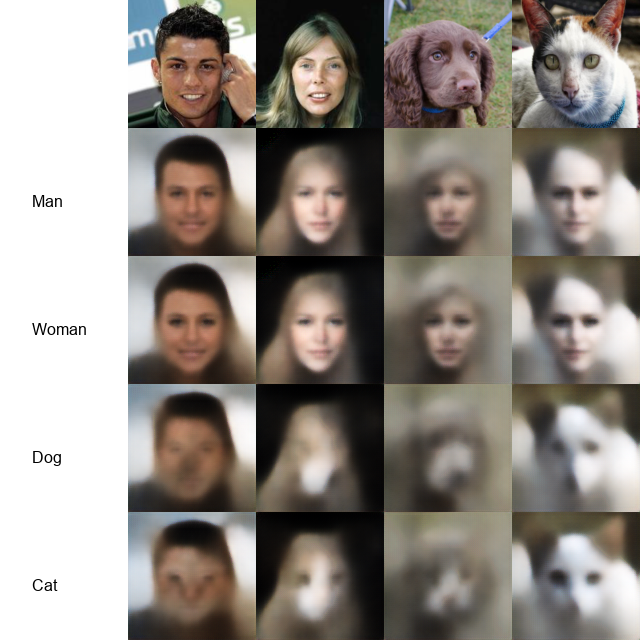

[12/1000][452/504][Time 21.30]
Unified LR across all optimizers: 0.00015508862860631812
--------------------Training Metrics--------------------
Trainer:  resnet
Inf: 0.0158	Gen: 0.1733	Rec: 0.1739	E: 0.0153	R: 0.0163	P: 0.3314


In [11]:
trainer_hub.train(celeba_animal_dataset)